## Experiment 1: Time Reduction
In this experiment, we try to evaluate how the experiment database reduces the total execution time of a series of incoming experiment objects (concrete pipelines for running on a dataset) related to the speed dating task on openml (https://www.openml.org/t/146607 ).

The experiment is carried out in the following way:

-   Start with an empty Graph
-   For every incoming experiment object:
   -   Find the common prefix using the graph
   -   If a common prefix is found, starting from the end of the path and "run" the rest of the pipeline
   -   For now, the runtime of each pipeline component is "1"

Report the following results. For every experiment object:

-  Time without the Graph
-  Time with the Graph
-  Total time of all the experiment objects without the graph
-  Total time of all the experiment objects with the graph

The pipelines for the experiment are the following:
- TASK_ID = [146607]  FLOW_IDS = [6970, 7707,6952,7103, 8330]

Where for each pipeline, we select the top 200 runs sorted by the predictive accuracy of the model (some of the pipelines were executed less than 200 times).



In [1]:
from openml import datasets, tasks, runs, flows, setups, config, evaluations
from workloadoptimization.essentials import Component, ExperimentObject, ExperimentGraph, ExperimentParser
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import uuid
import networkx as nx
import sklearn
from networkx.drawing.nx_agraph import graphviz_layout
from openmlstudy14.preprocessing import ConditionalImputer
%matplotlib inline


config.apikey = '8e2079508005379adb9a60798696134e'
config.server = 'https://www.openml.org/api/v1'
config.set_cache_directory(os.path.expanduser('~/openml-cache'))

Here we download the pipelines (called flow in openml) and trasnform them to scikit learn pipelines

In [2]:
#TASK_IDS = [31]
#FLOW_IDS = [5909,6268,6969,5804,6334,5995,8330,6970,6269,7707]
TASK_IDS = [146607]
FLOW_IDS = [6970, 7707, 6952, 7103, 8330]
# Query the flows and trasnform them to sklearn pipelines    
PIPELINES = {}
OPENML_FLOWS = {}
for p in FLOW_IDS:
    openMLFlow = flows.get_flow(p)
    OPENML_FLOWS[p] = openMLFlow
    PIPELINES[p] = flows.flow_to_sklearn(openMLFlow)

ValueError: Trying to deserialize a model with dependency sklearn==0.18.1 not satisfied.

The code for selecting the top 200 execution of the pipelines (called a 'Run' in openml) sorted by the predictive accuracy.

In [3]:
import pickle
def getTopRuns(numberOfRuns, pipeline, task):
    openMlEvaluations = evaluations.list_evaluations('predictive_accuracy', task= [task], flow = [pipeline])
    evaluationData = pd.DataFrame.from_dict(openMlEvaluations, orient='index')
    evaluationData['accuracy'] = evaluationData.apply(lambda eva: eva.values[0].value, axis = 1)
    evaluationData['run_id'] = evaluationData.apply(lambda eva: eva.values[0].run_id, axis = 1)
    # extracting the top ''numberOfRuns' runs
    topRuns = evaluationData.sort_values('accuracy',ascending=False)
    if (numberOfRuns>0):
        topRuns = topRuns[0:numberOfRuns]
    # retreiving the run objects from the top runs
    openMLRuns = runs.list_runs(task=[task], flow=[pipeline])
    experiments = pd.DataFrame.from_dict(openMLRuns,orient='index')
    Experiment = experiments.merge(topRuns,on='run_id').drop(columns=['uploader',0])
    Setup = pd.DataFrame.from_dict(setups.list_setups(setup=Experiment.setup_id, size =len(Experiment.setup_id) ), orient='index').reset_index()
    Setup.columns=['id', 'setup']

    return pd.merge(Setup, Experiment, how = 'inner', left_on='id', right_on='setup_id').drop(columns = ['id','setup_id'])[['run_id','task_id','flow_id', 'accuracy','setup']]
def extractExperiments(filePath, taskIds, flowIds):
    if os.path.isfile(filePath):
        return pd.read_pickle(filePath)
    frames = []
    for t in taskIds:
        for f in flowIds:
            frames.append(getTopRuns(200,f,t))
    Experiments = pd.concat(frames).reset_index(drop=True)
    Experiments.to_pickle(filePath)
    return Experiments

# This is time consuming, so it is better to persist the list of the runs to disk
# If you are changing the tasks or flow ids, remember to change the name of the file 
Experiments = extractExperiments('meta/picked-experiment-task-146607', TASK_IDS, FLOW_IDS)

In [6]:
Experiments.shape

(741, 5)

In [4]:
Experiments.head()
# run_id: openml unique id assigned to a specific execution of a pipeline on a task
# task_id: the task id (in this case the classification task for the speed dating dataset)
# flow_id: open ml unique id assigned to a specific pipeline (general structure of the pipeline)
# accuracy: the accuracy achieved for the specific execution
# ** VERY IMPORTANT Parmater** setup: the actual parameters used to run the pipeline in a specific execution 

,run_id,task_id,flow_id,accuracy,setup
0,6151241,146607,6970,0.866913,<openml.setups.setup.OpenMLSetup object at 0x1...
1,6146642,146607,6970,0.868704,<openml.setups.setup.OpenMLSetup object at 0x1...
2,6169694,146607,6970,0.867152,<openml.setups.setup.OpenMLSetup object at 0x1...
3,6157299,146607,6970,0.868704,<openml.setups.setup.OpenMLSetup object at 0x1...
4,6133852,146607,6970,0.867152,<openml.setups.setup.OpenMLSetup object at 0x1...


## Parsing the Results
Here, we parse the results of the 'Experiments' table and for each row, we create an object (ExperimentObject).
The "ExperimentObject" class has information about the specific experiment (running a pipeline with a set of parameters on a task).

## From Scikit learn

In [9]:
parser = ExperimentParser()
experimentObjects = parser.extractSKLearnPipelines(Experiments, PIPELINES)

## From OpenMLFlow

In [8]:
parser = ExperimentParser()
experimentObjects = parser.extractOpenMLFlows(Experiments, OPENML_FLOWS)

In [6]:
print 'run_id, pipeline_id, task_id, accuracy, list of the pipeline components: \n{}'.format(experimentObjects[0].toString())

run_id, pipeline_id, task_id, accuracy, list of the pipeline components: 
6151241, 6970, 146607, 0.866913, [u'imputation', u'hotencoding', u'variencethreshold', u'classifier']


## Profiling the runtime of the pipeline
OpenML does not provide detailed execution time of individual components. 
Here we try to profile the pipelines' components to provide an estimate of the execution time of each step and how time we can save. 
Ideally, this code should be entered into the project where for a given flow (with specific parameter) and a task (dataset + splits) the code returns the execution time of every component.

In [7]:
# Download the task, the flow and the dataset (training)
task = tasks.get_task(TASK_IDS[0])
dataset = datasets.get_dataset(dataset_id=task.dataset_id)
data = dataset.get_data()
train_indices,test_indices = task.get_train_test_split_indices()
X, y, attribute_names = dataset.get_data(
target=dataset.default_target_attribute,
return_attribute_names=True)
training = X[train_indices]
label = y[train_indices]

Since the pipelines in openml (flows) typically have null or default set of parameters, we provide candidate parameters by going through the executed pipelines and find a set of parameters for every component and use those to profile the execution time of the different components of the pipeline.

In [8]:
candidateParameters = {}
copiedObject = list(experimentObjects)
for ex in copiedObject:
    params = []
    if not candidateParameters.has_key(ex.flow):
        for com in ex.components:
            params.append(com.params)
        candidateParameters[ex.flow] = params

Here, we profile every pipeline (FLOW_IDS = [6970, 7707,6952,7103, 8330]) by running the components in order and measure the time for each component.

In [9]:
import ast
import time


def loadExistingRunProfiles(profilePath):
    read = open(profilePath, 'r')
    content = read.read()
    read.close()
    return ast.literal_eval(content)

runProfiles = loadExistingRunProfiles('meta/profiles.txt')
pipelinesCopy = PIPELINES.copy()
for pipelineKey,p in pipelinesCopy.iteritems():
    transformed = training
    if not runProfiles.has_key(pipelineKey):
        comp = []
        params = candidateParameters[pipelineKey]
        i = 0
        for k,c in p.steps:
            isModel = getattr(c, "fit_transform", True)
            start = time.time()
            if isModel == True:
                # some how the class weight parameter is messed up
                if (params[i].has_key('class_weight')):
                    params[i]['class_weight'] = None
                elif (params[i].has_key('max_leaf_nodes')):
                   
                    params[i]['max_leaf_nodes'] = 1
                c.set_params(**params[i])
                c.fit(transformed, label)
            else:
                if params[i].has_key('class_weight'):
                    params[i]['class_weight'] = 'balanced'
                c.set_params(**params[i])
                isSparse = getattr(transformed, "todense", False)
                if isSparse != False:
                     transformed = transformed.todense()
                transformed = c.fit_transform(transformed, label)
            end = time.time()
            comp.append(end - start)
            i = i + 1
        runProfiles[pipelineKey] = comp

# Write the profiles back to file
target = open('meta/profiles.txt', 'w')
target.write(str(runProfiles))
target.close()

runProfiles is a dictionary of id:List where id represents the pipeline id and the List represent the execution time for every component of the pipeline

Finally, we update our list of experiment objects with the execution time we measure during the profiling

In [11]:
for ex in experimentObjects:
    runProfile = runProfiles[ex.flow]
    total = 0
    for i in range(len(runProfile)):
        total = total + runProfile[i]
        ex.components[i].estimatedRunTime = runProfile[i]
    ex.estimatedRunTime = total

# Experiment Graph
Experiment graph represent the actual graph representation fo the experiment database, the code can be found in workloadoptimization/essentials.py

## Visualize the Graph
First, we load every experiment object into the graph, then we visualize the graph.
Components of the graph:
- Root: the original dataset from the task: 146607 (speed dating dataset)
- Edge: an actual transformation (step of the component)
- non-root and non-leaf nodes: the result of a transformation
- Leaf nodes: the final model 

All the edges are labeled with a tuple (component_name, weight) where weight is the number of times a certain component has been executed.

To make the figure more clear, we avoid adding labels to the edges that have a weight of one.
These are typically the edges connecting a node to the leaf (the model).
The reason the weight is 1 for nearly all of the model training components is that the hyperparameters seem to be tuned using the random search method, as a result, every model training component has a slightly different set of hyperparameters.

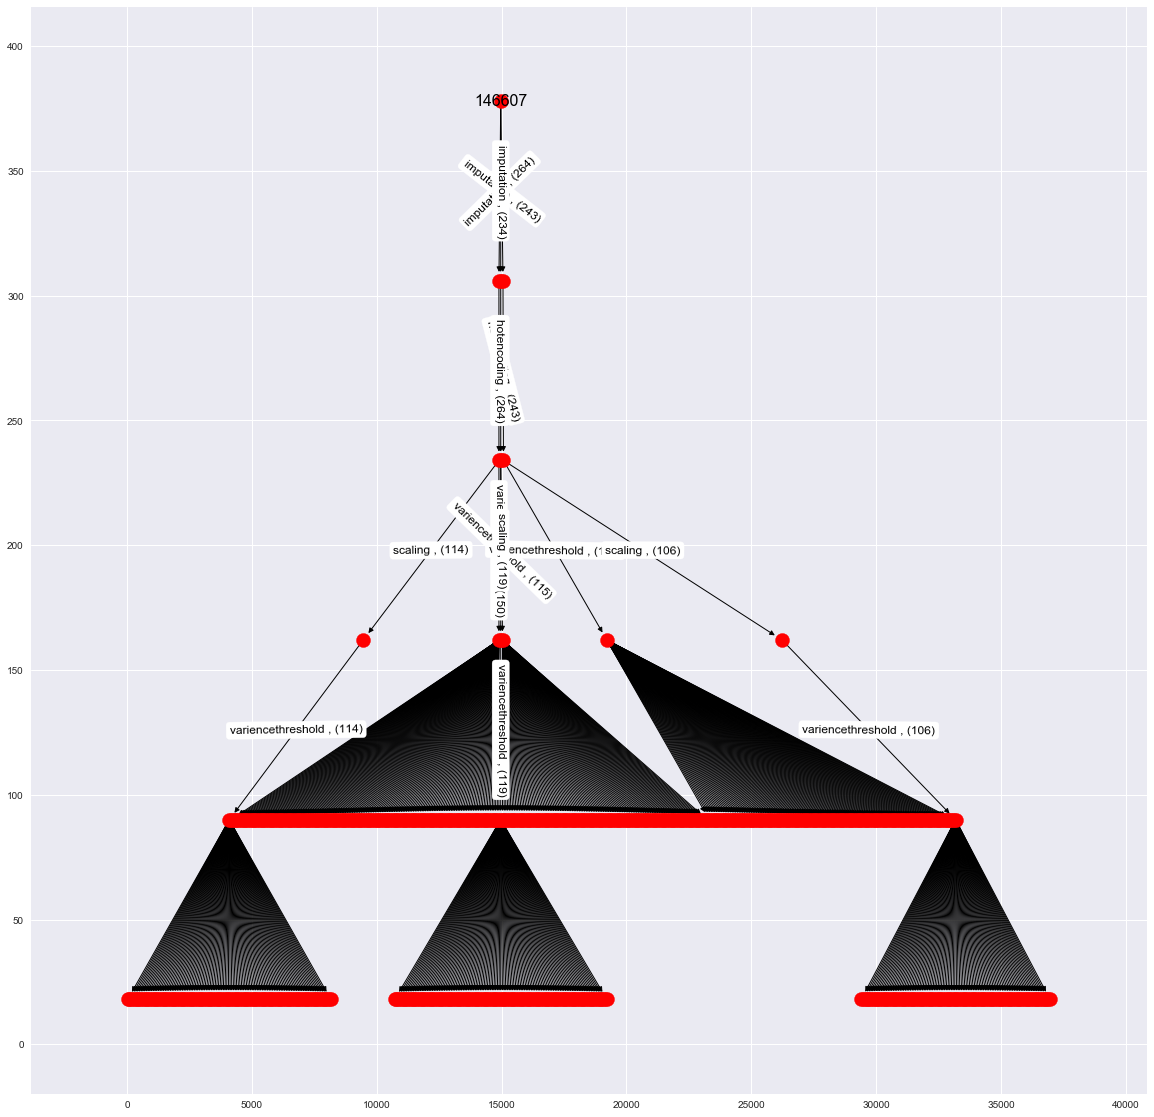

In [10]:
experimentGraph = ExperimentGraph()
for ex in experimentObjects:
    experimentGraph.insertExperimentObject(ex)
# Visualize the Graph
def drawGraph(graph):
    def prettyLabel(edgeLabel):
        if (edgeLabel['weight'] <= 1):
            return ''
        else:
            return '{} , ({})'.format(edgeLabel['name'], edgeLabel['weight'])
    edge_labels = dict([((u,v,),prettyLabel(d)) for u,v,d in graph.edges(data=True)])
    labels = dict({k for k in graph.nodes(data ='label')})
    pos = graphviz_layout(graph, prog='dot')
    gp = plt.figure(figsize=(20, 20))
    nx.draw_networkx_edge_labels(graph, pos, alpha=1, edge_labels=edge_labels, font_size=12)
    nx.draw_networkx_nodes(graph, pos, node_size=200)
    nx.draw_networkx_edges(graph, pos, alpha=1,arrows=True)
    nx.draw_networkx_labels(graph,pos,labels=labels, font_size=16)
    gp.savefig("graph.png")

drawGraph(experimentGraph.graph)

## Result of the Optimizations
To demonstrate the result of caching optimization, we perform a simple experiment.
We start with an empty graph (no prior history or knowledge)
For every ExperimentObject, which represent an actual execution of a pipeline on the dataset, we execute the pipeline and then update the graph.

After every execution, the graph has the knowledge of the previous executions and can optimize the execution of the current pipeline accordingly.


In [101]:
# Start with a fresh graph
realGraph = ExperimentGraph()

In [102]:
from random import shuffle
unoptimizedTime = []
optimizedTime = []
unoptimizedSteps = []
optimizedSteps = []
# Shuffle the objects to indicate we have no knowledge of the order of the incoming pipelines
shuffledList = list(experimentObjects)
shuffle(shuffledList)
for ex in shuffledList:
    # executes the object using the graph and returns the following:
    #    prefix: is the common path for the incoming pipeline and the existing graph, this indicates which components of the pipelie can be skipped
    #    optimziedExecTime; The exeuction time after optimizing the pipeline 
    prefix,steps,optimziedExecTime = realGraph.optimizeAndRun(ex)
    unoptimizedTime.append(ex.defaultRunTime())
    optimizedTime.append(optimziedExecTime)
    unoptimizedSteps.append(len(ex.components))
    optimizedSteps.append(steps)

[Text(0,0,u'Optimized'), Text(0,0,u'Unoptimized')]

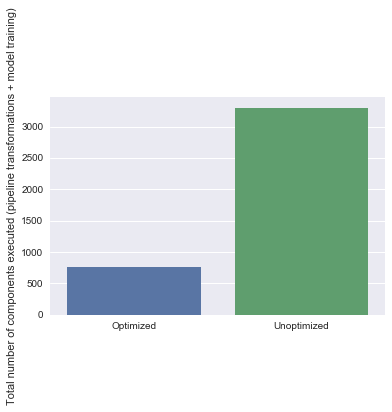

In [103]:
# total number of components executed
ax = sns.barplot(x = range(2), y = [sum(optimizedSteps),sum(unoptimizedSteps)])
ax.set(ylabel='Total number of components executed (pipeline transformations + model training)')
ax.set_xticklabels(['Optimized','Unoptimized'])

In [104]:
# improvement in the total number of steps
totalOptimized, totalUnoptimized = sum(optimizedSteps),sum(unoptimizedSteps)
improvement = (totalUnoptimized - totalOptimized)/float(totalUnoptimized) * 100
print 'total improvement in run time for the {} execution are {}%'.format(len(optimizedSteps), improvement)

total improvement in run time for the 741 execution are 77.1419921284%


The Figure above shows a big improvement in terms of the number of components that we avoid executing because we are reusing the result of the previous transformations instead of re-running them.
However, none of these components that were skipped are actually the model training component which for this specific use case takes around 99% of the time.
Next, we show the result of our optimizations on the execution time.

[Text(0,0,u'Optimized'), Text(0,0,u'Unoptimized')]

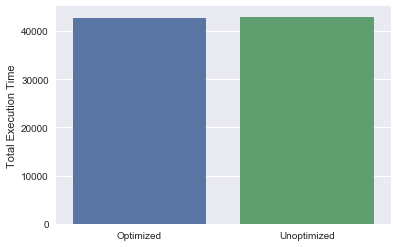

In [105]:
# total exeuction time
ax = sns.barplot(x = range(2), y = [sum(optimizedTime),sum(unoptimizedTime)])
ax.set(ylabel='Total Execution Time')
ax.set_xticklabels(['Optimized','Unoptimized'])

In [106]:
# improvement in the execution time
totalOptimized, totalUnoptimized = sum(optimizedTime),sum(unoptimizedTime)
improvement = (totalUnoptimized - totalOptimized)/totalUnoptimized * 100
print 'total improvement in run time for the {} execution are {}%'.format(len(optimizedTime), improvement)

total improvement in run time for the 741 execution are 0.504103621151%


## Conclusion
Unfortunately, the improvement in the estimated execution time is around 0.5%.
This is because most of the time is spent in the model training.
The figure will be slightly better for larger datasets as the transformations are also costly.
But for small datasets, we see very little improvement when compared to the non-optimized execution.

### What to do next
- In Grid Search hyperparameter search, we can still achieve a very good result, it seems in openml and scikit learn hyperparameter search is done using the random search approach and as a result, every search candidate is slightly different from the previous ones. I can look for some use cases that use grid search and show the improvement there.

- Hyperparameter optimization: With this graph, we have a lot of information that we can use for hyperparameter optimization. A downside of bayesian hyperparameter optimization is the very long execution time because every generated search candidate has to be fully trained. Since we have so many search candidates and their quality in our graph database, we can drastically reduce the search and propose very good hyperparameter configuration in a very short time


In [88]:
#ax = sns.barplot(range(len(optimized)), optimized)
#ax.set(xlabel='Incoming Pipelines', ylabel='Execution Time', xticks=[])

In [25]:
#ax = sns.barplot(range(len(unoptimized)), unoptimized)
#ax.set(xlabel='Incoming Pipelines', ylabel='Execution Time', xticks=[])